# Ash & Hughes-Oliver (2022): Confidence Bands for Hit Enrichment Curves

The following is a replication of the applied analysis of Ash & Hughes-Oliver (2022), which uses data from Empereur-Mot et al. (2016). The authors discuss estimation of the 'hit enrichment curve', which is a function commonly used to summarize effectiveness of a virtual drug screening campaign. In the example, the authors are focused on estimating the hit enrichment curve for the protein regulating gene peroxisome proliferator-activated receptor gamma (PPARg). This was done using three different docking methods: Surflex-dock, ICM, and Vina. To compare the hit enrichment curves from these different docking methods, the authors discuss the use of confidence bands. The original materials for the paper can be found [HERE](https://github.com/jrash/Enrichment-Inference-Supplemental-Materials). 

Here, we will show how `delicatessen` can be used to construct confidence bands in the context of hit enrichment curves.

## Setup

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import delicatessen
from delicatessen import MEstimator
from delicatessen.estimating_equations import ee_regression
from delicatessen.utilities import inverse_logit

print("Versions")
print("NumPy:       ", np.__version__)
print("SciPy:       ", sp.__version__)
print("pandas:      ", pd.__version__)
print("Matplotlib:  ", mpl.__version__)
print("Delicatessen:", delicatessen.__version__)

Versions
NumPy:        1.25.2
SciPy:        1.11.2
pandas:       1.4.1
Matplotlib:   3.9.2
Delicatessen: 3.2


Data is available from the GitHub page linked above.

In [2]:
d = pd.read_csv("data/pparg.csv")

# Extracting Relevant data for hit enrichment curve estimation
active = np.asarray(d['surf_actives']) # Outcome variable for hit enrichment
x_mxz = np.asarray(d['maxz_scores'])   # Max Z-score docking
x_srf = np.asarray(d['surf_scores'])   # Surflex-docking
x_icm = np.asarray(d['icm_scores'])    # ICM docking

## Empirical Distribution Function

As in Ash & Hughes-Oliver, we are interested in estimating the hit enrichment curve. They define the hit enrichment curve at the point $s$ as the recall curve divided by the percent-captured curve. Here, $s$ is a set of scores the correspond to the belief that a ligand is active. For a given threshold $s$, the estimator of the hit enrichment curve is 
$$ \hat{H}(s) = \frac{\hat{\beta}(s)}{\hat{\rho}(s)} $$
where 
$$ \hat{\beta}(s) = \frac{\sum_{i=1}^n A_i I(S_i \ge s)}{\sum_{i=1}^n A_i}, $$ 
$$ \hat{\rho}(s) = \frac{1}{n} \sum_{i=1}^n I(S_i \ge s), $$ 
$A_i$ denotes a 'hit' or the activity value, and $S_i$ denotes the active ligand score. To plot the estimated hit enrichment curve, we will plot the ordered pairs $(\rho(s), \beta(s))$ for $s$.

The estimating function for these parameters are
$$ \psi(O_i; \beta(s)) = A_i \left( I(S_i \ge s) - \beta(s) \right) $$
$$ \psi(O_i; \beta(s)) = I(S_i \ge s) - \rho(s) $$
respectively. However, we are interested in plotting the complete curve (not only one point). To estimate this function, let $s_k \in \{s_1, ..., s_K\}$ denote the set of unique observed values of $S_i$ where $A_i = 1$ in the data. Here, the stacked estimating functions expand to the number $K$.
Note the the number of estimating functions (and parameters) is now a function of $n$ (via $K$). This seemingly subtle change has important implications for inference. Specifically, the theory from Stefanski & Boos 2002 is no longer adequate. Instead, we need an extension. See Kosorok 2008 for those details.

We will start by estimating the cumulative distribution function for Max Z-score docking.

In [3]:
unique_mxz = np.unique(x_mxz[active == 1])[1:]  # All unique values for A=1
n_unique_mxz = len(unique_mxz)                   # Number of unique values, K

In [4]:
def psi_edf(theta):
    # Separating parameters into subsets
    beta = theta[: n_unique_mxz]
    rho = theta[n_unique_mxz: n_unique_mxz*2]

    # A fast way to compute the indicator terms without a for-loop
    indicator_matrix = (x_mxz >= unique_mxz[:, None]).astype(int)

    # Recall fractions at all ranks
    ef_hedf = active*(indicator_matrix.T - beta).T
    # Fraction tests at all ranks
    ef_fedf = indicator_matrix.T - rho

    # Stacking the estimating functions
    return np.vstack([ef_hedf, ef_fedf.T])

In [5]:
init_vals = list(np.linspace(0.99, 0.01, n_unique_mxz)) + list(np.linspace(0.99, 0.01, n_unique_mxz))
estr = MEstimator(psi_edf, init=init_vals)
estr.estimate(solver='lm')

We now have all the pieces estimated that we need to create our figure. 

While we could present confidence intervals in our figure, these can be misleading when presenting functions. Confidence intervals claim to cover the parameter at the advertised rate. As such, coverage of a *function* will be below that level. Therefore, when presenting functions we should instead consider presenting confidence bands. Confidence bands modify the critical value so that a set of modified confidence intervals have coverage at the advertised rate. The most familiar method is the Bonferroni correction. However, the Bonferroni correction can be overly conservative (and is not appropriate to apply in this setting). Instead, we use the sup-t method as described in the referenced paper. See Zivich et al. (2025) for further details.

The following function inside the `MEstimator` class allows for computation of the confidence bands.

In [6]:
cbands = estr.confidence_bands(method='supt', seed=2101101)[:n_unique_mxz, :]

To illustrate the difference between the two methods to compute confidence regions, we will also compute the confidence intervals here.

In [7]:
cints = estr.confidence_intervals()[:n_unique_mxz, :]

Now we will recreate the plot in Figure 5 of Ash & Hughes-Oliver.

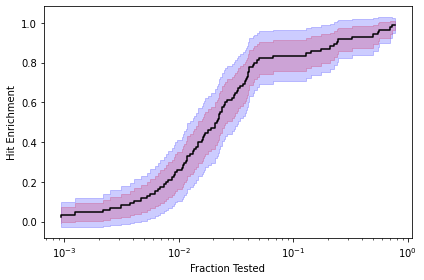

In [8]:
x_vals = estr.theta[n_unique_mxz: ]
plt.step(x_vals, estr.theta[:n_unique_mxz], where='post', color='k')
plt.fill_between(x_vals, cints[:, 0], cints[:, 1], alpha=0.2, color='red', step='post')
plt.fill_between(x_vals, cbands[:, 0], cbands[:, 1], alpha=0.2, color='blue', step='post')
plt.xscale('log')
plt.xlabel("Fraction Tested")
plt.ylabel("Hit Enrichment")
plt.tight_layout()
plt.show()

The estimated hit enrichment curve is comparable to the one reported in Figure 5 of the paper. There might be slight differences due to minor differences in estimators (we ignore ties) and the sup-t confidence bands rely on a resampling process (so there can be Monte-Carlo errors).

Importantly, we see that the confidence intervals are much narrower than the confidence bands. This illustrates how the confidence *intervals* can be misleading when making inferences for functions. Hence why focusing on the confidence *bands* in settings like this is preferred for statistical inference.

Now let's compute and plot the functions for the their methods described in the paper and their corresponding confidence bands.

In [9]:
# Storing outputs from max Z-scores
beta_mxz = estr.theta[:n_unique_mxz]
rho_mxz = estr.theta[n_unique_mxz:]
cb_mxz = cbands

In [10]:
# Computing for Surflex method
unique_srf = np.unique(x_srf[active == 1])[1:]  # All unique values for A=1
n_unique_srf = len(unique_srf)                  # Number of unique values, K

def psi_edf(theta):
    # Separating parameters into subsets
    beta = theta[: n_unique_srf]
    rho = theta[n_unique_srf: n_unique_srf*2]

    # A fast way to compute the indicator terms without a for-loop
    indicator_matrix = (x_srf >= unique_srf[:, None]).astype(int)

    # Recall fractions at all ranks
    ef_hedf = active*(indicator_matrix.T - beta).T
    # Fraction tests at all ranks
    ef_fedf = indicator_matrix.T - rho

    # Stacking the estimating functions
    return np.vstack([ef_hedf, ef_fedf.T])


# Estimation
init_vals = list(np.linspace(0.99, 0.01, n_unique_srf)) + list(np.linspace(0.99, 0.01, n_unique_srf))
estr = MEstimator(psi_edf, init=init_vals)
estr.estimate(solver='lm')

# Confidence bands computation
cbands = estr.confidence_bands(method='supt', seed=2101101)[:n_unique_srf, :]

# Storing outputs
beta_srf = estr.theta[:n_unique_srf]
rho_srf = estr.theta[n_unique_srf:]
cb_srf = cbands

In [11]:
# Computing for ICM method
unique_icm = np.unique(x_icm[active == 1])[1:]  # All unique values for A=1
n_unique_icm = len(unique_icm)                  # Number of unique values, K

def psi_edf(theta):
    # Separating parameters into subsets
    beta = theta[: n_unique_icm]
    rho = theta[n_unique_icm: n_unique_icm*2]

    # A fast way to compute the indicator terms without a for-loop
    indicator_matrix = (x_icm >= unique_icm[:, None]).astype(int)

    # Recall fractions at all ranks
    ef_hedf = active*(indicator_matrix.T - beta).T
    # Fraction tests at all ranks
    ef_fedf = indicator_matrix.T - rho

    # Stacking the estimating functions
    return np.vstack([ef_hedf, ef_fedf.T])


# Estimation
init_vals = list(np.linspace(0.99, 0.01, n_unique_icm)) + list(np.linspace(0.99, 0.01, n_unique_icm))
estr = MEstimator(psi_edf, init=init_vals)
estr.estimate(solver='lm')

# Confidence bands computation
cbands = estr.confidence_bands(method='supt', seed=2101101)[:n_unique_icm, :]

# Storing outputs
beta_icm = estr.theta[:n_unique_icm]
rho_icm = estr.theta[n_unique_icm:]
cb_icm = cbands

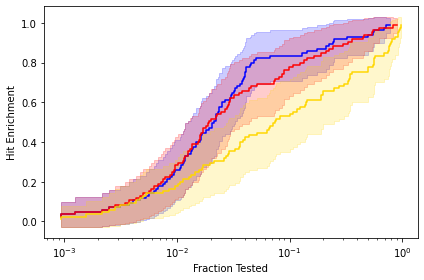

In [12]:
# Max Z-score Plot
plt.step(rho_mxz, beta_mxz, where='post', color='blue')
plt.fill_between(rho_mxz, cb_mxz[:, 0], cb_mxz[:, 1], alpha=0.2, color='blue', step='post')
# Surflex Plot
plt.step(rho_srf, beta_srf, where='post', color='red')
plt.fill_between(rho_srf, cb_mxz[:, 0], cb_mxz[:, 1], alpha=0.2, color='red', step='post')
# ICM Plot
plt.step(rho_icm, beta_icm, where='post', color='gold')
plt.fill_between(rho_icm, cb_icm[:, 0], cb_icm[:, 1], alpha=0.2, color='gold', step='post')
# Formatting plot
plt.xscale('log')
plt.xlabel("Fraction Tested")
plt.ylabel("Hit Enrichment")
plt.tight_layout()
plt.show()

The plot closely aligns with the complete Figure 5.

## References

Ash JR, & Hughes-Oliver JM. (2022). "Confidence bands and hypothesis tests for hit enrichment curves". *Journal of Cheminformatics*, 14(1), 50.

Empereur-Mot C, Zagury JF, & Montes M. (2016). "Screening explorer–An interactive tool for the analysis of screening results". *Journal of Chemical Information and Modeling*, 56(12), 2281-2286.

Kosorok MR. (2008). Introduction to empirical processes and semiparametric inference. New York, NY: Springer New York.

Zivich PN, Cole SR, Greifer N, Montoya LM, Kosorok MR, & Edwards JK. (2025). "Confidence Regions for Multiple Outcomes, Effect Modifiers, and Other Multiple Comparisons". *arXiv:2510.07076*